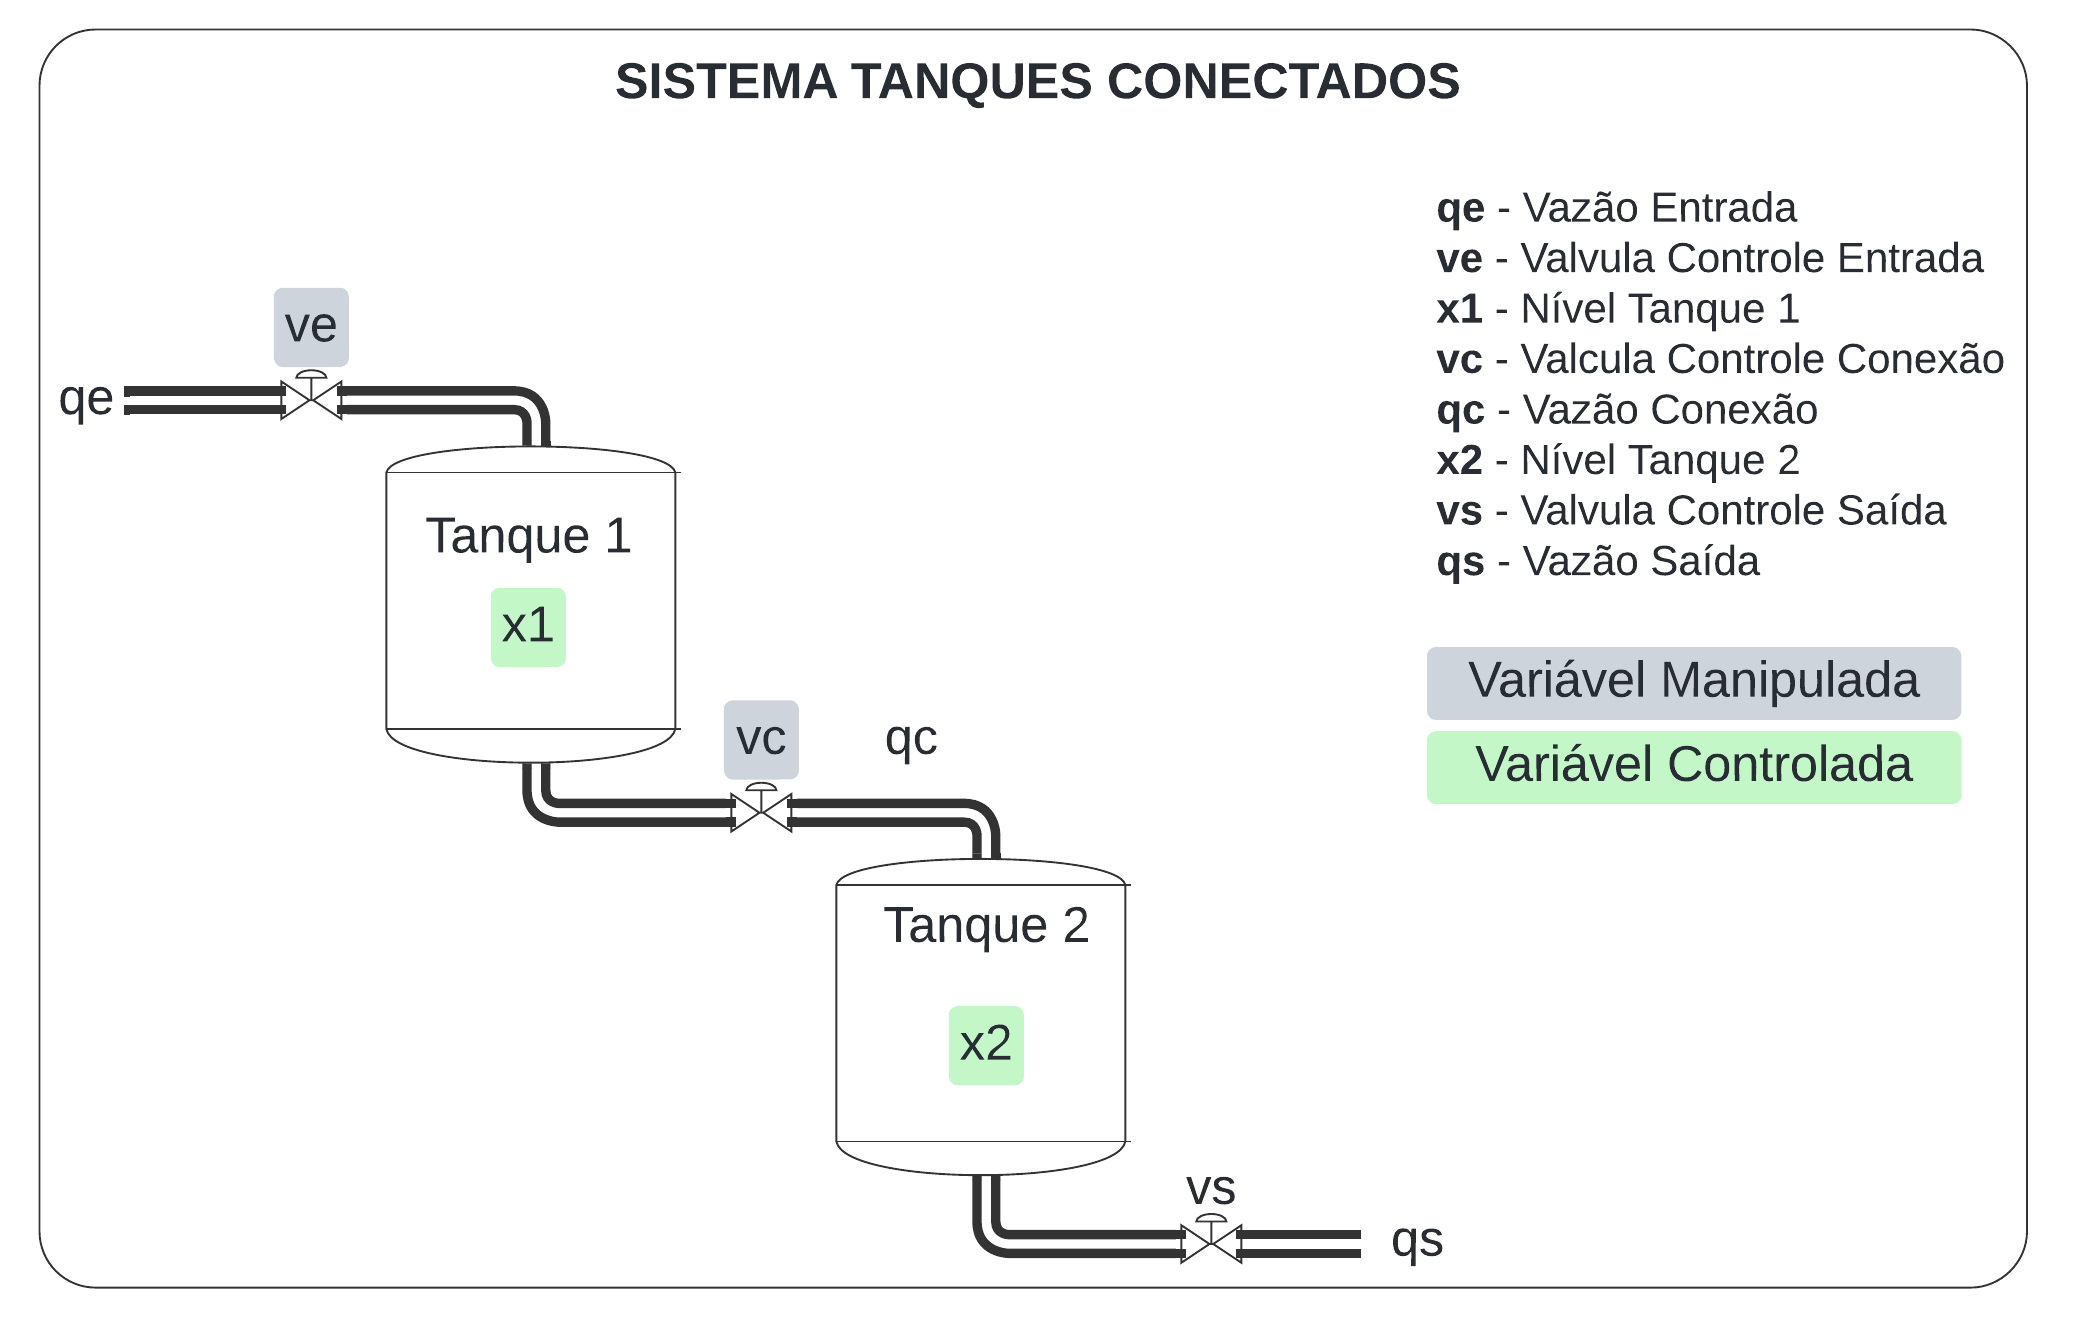

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, Lambda
from keras.models import Model, Sequential, load_model
import time
from functools import partial
import joblib
from tqdm import tqdm
import os
from sklearn.metrics import mean_squared_error

tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()

In [14]:
# Parametros Globais
np.random.seed(56)
k1 = 2
k2 = 1
ts = 0.3
pmc_horizon = 5
model_horizon = 5
num_data = 10000
data_name = f"data-{num_data}_hor-{model_horizon}_ts-{ts}"

plot_name = f'pmc_nn-2tanques_{data_name}'
path = f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_{data_name}'
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)
print(f'O diretório  é: {os.getcwd()}')
print(f'O plot_name  é: {plot_name}')

O diretório  é: /content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_data-10000_hor-5_ts-0.3
O plot_name  é: pmc_nn-2tanques_data-10000_hor-5_ts-0.3


In [15]:
def plot_sim_history(sim_history):
  dpi = 600
  size_view = (20, 10)
  size_fig = (20, 5)

  fig, axs = plt.subplots(3, 1, figsize=size_view)

  axs[0].plot(sim_history['x1'], label='x1')
  axs[0].plot(sim_history['ref1'], label='ref1', linestyle=':')
  axs[0].plot(sim_history['x2'], label='x2')
  axs[0].plot(sim_history['ref2'], label='ref2', linestyle=':')

  axs[0].set_xlabel("Steps/Time(s)")
  axs[0].set_ylabel("Level(m)")
  axs[0].set_title('Controle Preditivo - Tanques Conectados')
  axs[0].set_xticks(np.arange(0, 1100, 100))
  axs[0].set_xlim(0, 1000)

  axs[0].axvspan(800, 900, color='red', alpha=0.3, label='Ruído + 10%')

  axs[0].legend()
  axs[0].grid(True)  # Adiciona uma grade ao gráfico

  axs[1].plot(sim_history['qe'], label='qe')
  axs[1].plot(sim_history['qc'], label='qc')

  axs[1].set_ylabel("(m^3/s)")
  axs[1].set_title('Sinal Controle Preditivo - Tanques Conectados')
  axs[1].set_xticks(np.arange(0, 1100, 100))
  axs[1].set_xlim(0, 1000)
  axs[1].legend()
  axs[1].grid(True)  # Adiciona uma grade ao gráfico

  axs[2].plot(sim_history['erro1'], label='erro1')
  axs[2].plot(sim_history['erro2'], label='erro2')
  axs[2].plot(sim_history['erro'], label='erro médio')

  axs[2].set_ylabel("erro (m)")
  axs[2].set_title('Erro Controle Preditivo - Tanques Conectados')
  axs[2].set_xticks(np.arange(0, 1100, 100))
  axs[2].set_xlim(0, 1000)
  axs[2].legend()
  axs[2].grid(True)  # Adiciona uma grade ao gráfico

  fig.tight_layout()  # Ajusta o layout

  fig.savefig(f'{plot_name}.png', format='png', dpi=dpi)

  # Salvar cada subplot individualmente
  for i, ax in enumerate(axs):
      # Criar uma nova figura para cada subplot
      fig_single, ax_single = plt.subplots(figsize=size_fig)
      # Copiar o conteúdo do subplot original para a nova figura
      for line in ax.get_lines():
          ax_single.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), linestyle=line.get_linestyle())
      ax_single.set_xlim(ax.get_xlim())
      ax_single.set_ylim(ax.get_ylim())
      ax_single.set_xticks(ax.get_xticks())
      ax_single.set_title(ax.get_title())
      ax_single.set_xlabel(ax.get_xlabel())
      ax_single.set_ylabel(ax.get_ylabel())
      if i == 0:
        ax_single.axvspan(800, 900, color='red', alpha=0.3, label='Ruído + 10%')
      ax_single.legend()
      ax_single.grid(True)  # Adiciona uma grade ao gráfico

      # Salvar a figura individual
      fig_single.tight_layout()
      fig_single.savefig(f'{plot_name}-{i + 1}.png', format='png', dpi=dpi)
      plt.close(fig_single)  # Fechar a figura para liberar memória

  plt.show()

  fig2 = plt.figure(figsize=size_fig)
  plt.plot(sim_history['control_elapsed'], label='Tempo de Resposta')
  mean_value = np.mean(sim_history['control_elapsed'])
  plt.axhline(y=mean_value, color='r', linestyle='--', label=f'Média = {mean_value:.2f} ms')

  plt.ylabel("tempo (ms)")
  plt.title('Tempo de Resposta Controle Preditivo - Tanques Conectados')
  plt.xticks(np.arange(0, 1100, 100))
  plt.xlim(0, 1000)
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico

  fig2.savefig(f'{plot_name}-tempo_resposta.png', format='png', dpi=dpi)

  plt.show()

Processo que representa um o nível de um tanque com um registro

In [16]:
import math

# Process Const
area = 16
max_level = 12
def tank_xdot(x, qe, valve=100, valve_k = 1):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, valve_k = 1, t=0.2):
  a=x0
  b=qe
  c=valve
  #call 1
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  if np.isnan(x):
    x = 0

  if np.isnan(qs):
    qs = 0

  return x, qs;

In [17]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.width', 1000)

In [18]:
scaler_x_train = joblib.load(f"datatrain_scaler-x_{data_name}.pkl")

Modelo de Rede Neural

In [19]:
model = Sequential()
model.add(Lambda(lambda x: x[:]))
model.add(Dense(32, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(2, kernel_initializer=tf.initializers.zeros))
model.load_weights(f"model-weights_{data_name}/model")

In [20]:
def pmc_error(qe, vc, vs, x1, x2, ref1, ref2):

  pred_x = np.array([[x1, qe, vc, x2, vs]])
  pred_x = scaler_x_train.transform(pred_x)
  pred_y = model.predict(pred_x, verbose = None);

  if qe > 0 or vc > 0:
    x1 += pred_y[0][0]

  if vc > 0 or vs > 0:
    x2 += pred_y[0][1]

  error1 = np.sqrt(((x1 - ref1) ** 2))
  error2 = np.sqrt(((x2 - ref2) ** 2))
  error = error1 + error2

  return error1, error2, error;
#pmc_error(0, 0, 0, [2, 2], [4,4], horizon=10)

In [21]:
def pmc_error_h1(qe, vc, vs, x1, x2, ref1, ref2, horizon=5):

  ref_horizon1 = np.ones(horizon) * ref1
  ref_horizon2 = np.ones(horizon) * ref2
  pred_history = np.zeros((0,2))

  #Calcula o erro futuro de acordo com a ação aleatória
  for j in range(horizon):

    pred_x = np.array([[x1, qe, vc, x2, vs]])
    pred_x = scaler_x_train.transform(pred_x)
    pred_y = model.predict(pred_x, verbose = None);

    if qe > 0 or vc > 0:
      x1 += pred_y[0][0]

    if vc > 0 or vs > 0:
      x2 += pred_y[0][1]

    pred_history = np.vstack((pred_history, (x1, x2)))

  error1 = mean_squared_error(pred_history[:,0], ref_horizon1)
  error2 = mean_squared_error(pred_history[:,1], ref_horizon2)
  error = error1 + error2

  return error1, error2, error;

#pmc_error_h1(qe=2, vc=100, vs=100, x1=2, x2=2, ref1=4, ref2=4, horizon=5)

In [22]:
def pmc_error_modelo(qe, vc, vs, x1, x2, ref1, ref2, horizon=10):
  pred_history = np.zeros((0,5))

  for j in range(horizon):

    ref_horizon1 = np.ones((horizon,1)) * ref1
    ref_horizon2 = np.ones((horizon,1)) * ref2

    x1, qc = tank_rk(x1, qe, vc, k1, ts);
    x2, qs = tank_rk(x2, qc, vs, k2, ts);

    pred_history = np.vstack((pred_history, (qe, vc, vs, x1, x2)))

  error1 = np.sqrt(((pred_history[:,3] - ref_horizon1) ** 2).mean())
  error2 = np.sqrt(((pred_history[:,4] - ref_horizon2) ** 2).mean())
  error = error1 + error2

  return error1, error2, error;

#pmc_error_modelo(0, 0, 0, [2, 2], [4,4], horizon=10)

In [23]:
# Parametros MPC
max_delta_qe = 1
max_qe = 4
min_qe = 0

max_delta_vc = 50
max_vc = 100
min_vc = 0

def pmc_control(qe, vc, vs, x1, x2, ref1, ref2, horizon=10, num_randactions=10, control_nn=True):

  global analise
  global i_Analise
  i_Analise += 1

  best_qe = qe
  best_vc = vc

  error_nn1, error_nn2, error_nn = pmc_error(qe, vc, vs, x1, x2, ref1, ref2)
  error_model1, error_model2, error_model = pmc_error_modelo(qe, vc, vs, x1, x2, ref1, ref2, horizon)

  if control_nn:
    min_error1 = error_nn1
    min_error2 = error_nn2
    min_error = error_nn
  else:
    min_error1 = error_model1
    min_error2 = error_model2
    min_error = error_model

  # Faz um loop com a quantidade num_randactions de ações aleatorias
  for i in range (num_randactions):

    action_qe = qe
    action_vc = vc

    #Seleciona um delta aleatório para aplicar na nova ação
    action_qe += max_delta_qe * np.random.uniform(-1, 1)

    if action_qe > max_qe:
        action_qe = max_qe

    if action_qe < min_qe:
        action_qe = min_qe

    action_vc += max_delta_vc * np.random.uniform(-1, 1)

    if action_vc > max_vc:
        action_vc = max_vc

    if action_vc < min_vc:
        action_vc = min_vc

    error_nn1, error_nn2, error_nn = pmc_error(action_qe, action_vc, vs, x1, x2, ref1, ref2)
    error_model1, error_model2, error_model = pmc_error_modelo(action_qe, action_vc, vs, x1, x2, ref1, ref2, horizon)

    if control_nn:
      error1 = error_nn1
      error2 = error_nn2
      error = error_nn
    else:
      error1 = error_model1
      error2 = error_model2
      error = error_model

    analise.append([i_Analise, qe, qc,  x1, x2, min_error, error_nn, error_model, error_nn-error_model, action_qe, action_vc, best_qe, best_vc])

    if error < min_error:
        best_qe = action_qe
        best_vc = action_vc
        return best_qe, best_vc

  return best_qe, best_vc
#error1, error2, error = pmc_error_h1(qe=0, vc=0, vs=100, x1=0, x2=0, ref1=6, ref2=6, horizon=5)
#error_m1, error_m2, error_m = pmc_error_modelo(qe=0, vc=0, vs=100, x1=0, x2=0, ref1=6, ref2=6, horizon=5)
#qe, qc = pmc_control(qe=0, vc=0, vs=100, x1=0, x2=0, ref1=6, ref2=6, horizon=10, num_randactions=5, control_nn=True)
#print([error1, error2, error])
#print([error_m1, error_m2, error_m])
#print([qe, qc])

100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s]


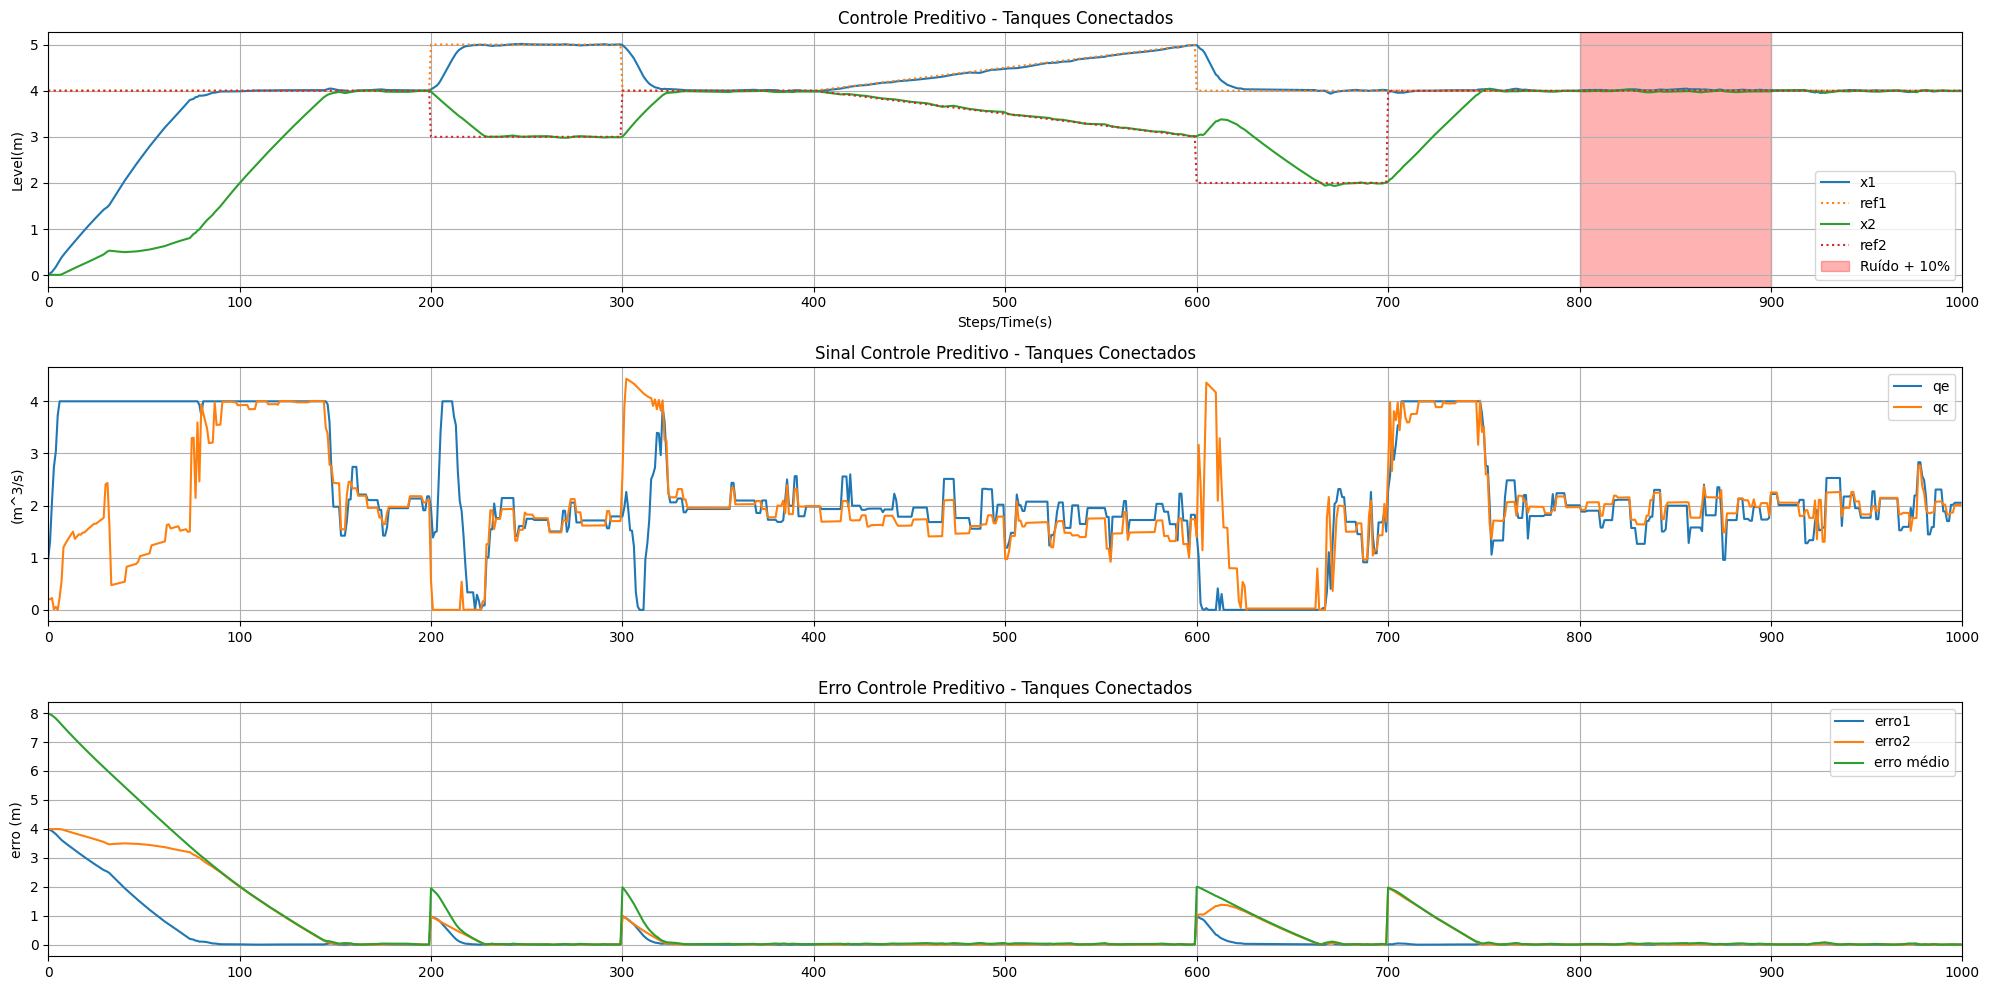

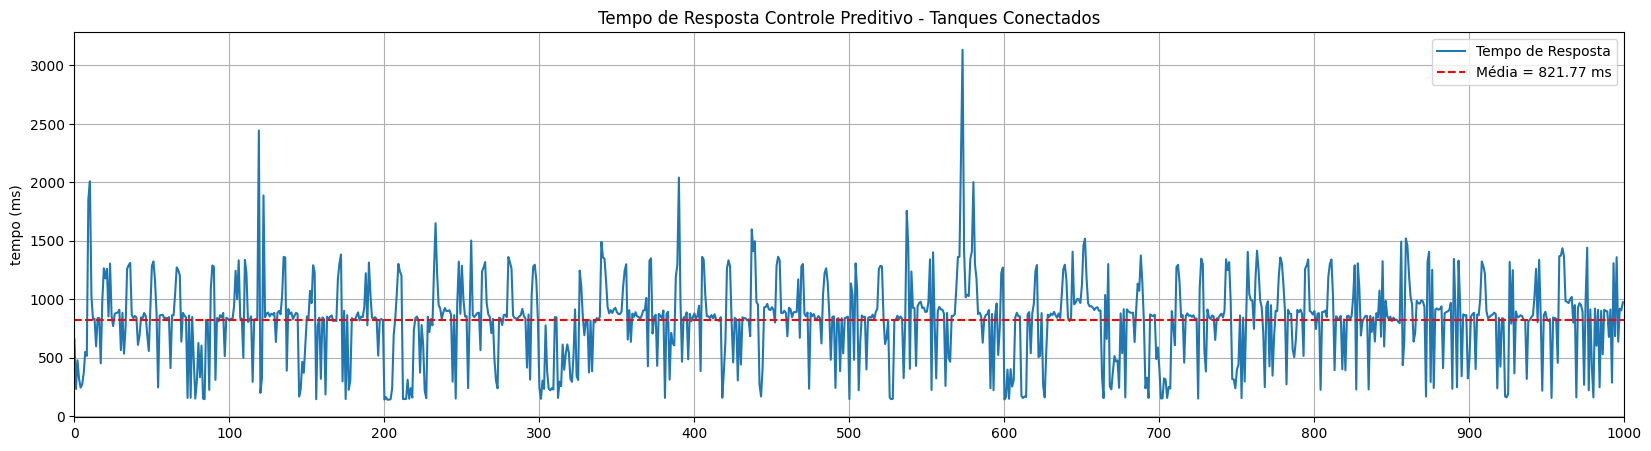

In [24]:
num_randactions=10

analise_columns = ["i", "qe", "qc", "x1", "x2", "min_error", "error_nn", "error_real", "dif_erro", "action_qe", "action_vc", "best_qe", "best_vc"]
analise = []

i_Analise = 0

#Simulation Parameters
num_sim = 1000

#Set initial conditions
sim_history_columns = ["qe", "qc", "vc", "qs", "vs", "x1", "x2", "ref1", "ref2", "erro1", "erro2", "erro", "control_elapsed"]
sim_history = []

x1 = 0;
x2 = 0;

ref1 = 4
ref2 = 4

qe = 0
qc = 0
vc = 100
vs = 100
noise = 1.0

for run in tqdm(range(num_sim)):

    if run == 200:
      ref1 += 1;
      ref2 -= 1;

    if run == 300:
      ref1 -= 1;
      ref2 += 1;

    if 400 < run <= 600:
      ref1 += 1/200;
      ref2 -= 1/200;

    if run == 600:
      ref1 -= 1;
      ref2 -= 1;

    if run == 700:
      ref2 += 2;

    if run >= 800:
      noise = 1.1;

    if run >= 900:
      noise = 1.0;

    control_elapsed_start = time.time()
    qe, vc = pmc_control(qe, vc, vs, x1, x2, ref1, ref2, horizon=pmc_horizon,num_randactions=num_randactions, control_nn=True)
    control_elapsed = (time.time() - control_elapsed_start) * 1000

    x1, qc = tank_rk(x1, qe*noise, vc, k1, ts)
    x2, qs = tank_rk(x2, qc      , vs, k2, ts)

    error1 = np.sqrt((x1 - ref1) ** 2)
    error2 = np.sqrt((x2 - ref2) ** 2)
    error = error1 + error2

    sim_history.append([qe, qc, vc, qs, vs, x1, x2, ref1, ref2, error1, error2, error, control_elapsed])
sim_history=pd.DataFrame(data=sim_history, columns=sim_history_columns)
sim_history.to_csv(f"sim_history{data_name}.csv", index=False)
plot_sim_history(sim_history)

In [25]:
sim_history

,qe,qc,vc,qs,vs,x1,x2,ref1,ref2,erro1,erro2,erro,control_elapsed
0,0.968384,0.207079,83.341227,0.056122,100,0.015610,0.003188,4.000,4.000,3.984390,3.996812,7.981202,661.311388
1,1.315787,0.203978,52.980268,0.075889,100,0.037073,0.005758,4.000,4.000,3.962927,3.994242,7.957169,234.933615
2,2.070390,0.226492,42.146114,0.091796,100,0.072211,0.008426,4.000,4.000,3.927789,3.991574,7.919363,479.073524
3,2.738825,0.012414,1.767275,0.083732,100,0.123358,0.007013,4.000,4.000,3.876642,3.992987,7.869629,321.660519
4,3.033915,0.056885,6.717674,0.080847,100,0.179265,0.006537,4.000,4.000,3.820735,3.993463,7.814198,246.361971
5,3.733397,0.000000,0.000000,0.071456,100,0.249266,0.005109,4.000,4.000,3.750734,3.994891,7.745625,272.637844
6,4.000000,0.240579,21.264004,0.089982,100,0.320015,0.008096,4.000,4.000,3.679985,3.991904,7.671889,368.117094
7,4.000000,0.548885,44.220793,0.127738,100,0.385170,0.016321,4.000,4.000,3.614830,3.983679,7.598509,551.566124
8,4.000000,1.199317,90.569166,0.189163,100,0.438377,0.035795,4.000,4.000,3.561623,3.964205,7.525829,517.153978
9,4.000000,1.268271,90.569166,0.235727,100,0.490234,0.055572,4.000,4.000,3.509766,3.944428,7.454194,1857.953787


In [26]:
sim_history.describe()

,qe,qc,vc,qs,vs,x1,x2,ref1,ref2,erro1,erro2,erro,control_elapsed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.160408,1.965882,49.669974,1.753926,100.0,4.050666,3.224190,4.19950,3.600500,0.198812,0.517537,0.716349,821.766599
std,1.082031,1.000213,25.137822,0.384815,0.0,0.765357,1.029343,0.35566,0.637945,0.636659,1.033748,1.578569,347.547801
min,0.000000,0.000000,0.000000,0.056122,100.0,0.015610,0.003188,4.00000,2.000000,0.000048,0.000027,0.000566,142.138004
25%,1.705591,1.545860,38.076397,1.732536,100.0,4.000956,3.001681,4.00000,3.253750,0.007133,0.008920,0.021604,660.265625
50%,1.952147,1.852946,46.627118,1.900972,100.0,4.014237,3.613695,4.00000,4.000000,0.014817,0.018440,0.036235,857.239008
75%,2.453373,2.148111,54.422487,1.995578,100.0,4.298766,3.982330,4.24625,4.000000,0.029187,0.447377,0.501530,935.738266
max,4.000000,4.432788,100.000000,2.009467,100.0,5.015105,4.037958,5.00000,4.000000,3.984390,3.996812,7.981202,3134.219408


In [27]:
analise=pd.DataFrame(data=analise, columns=analise_columns)
analise.loc[analise['i'] == 150]

,i,qe,qc,x1,x2,min_error,error_nn,error_real,dif_erro,action_qe,action_vc,best_qe,best_vc
1203,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.132164,0.127387,0.004776,1.844284,42.303374,2.646396,68.456897
1204,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.133724,0.073082,0.060642,2.201365,83.085444,2.646396,68.456897
1205,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.115350,0.065261,0.050088,2.743401,86.630935,2.646396,68.456897
1206,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.153462,0.081176,0.072286,2.606595,90.008582,2.646396,68.456897
1207,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.077559,0.052768,0.024790,1.855699,70.998751,2.646396,68.456897
1208,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.199990,0.104859,0.095131,2.982817,100.000000,2.646396,68.456897
1209,150,2.646396,2.753555,4.044762,3.941594,0.052296,0.007436,0.058055,-0.050618,1.977802,60.607765,2.646396,68.456897


In [28]:
analise.describe()

,i,qe,qc,x1,x2,min_error,error_nn,error_real,dif_erro,action_qe,action_vc,best_qe,best_vc
count,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000,8112.000000
mean,502.873767,2.176074,1.951240,4.053108,3.244199,0.611182,0.746229,0.717378,0.028851,2.138296,48.795026,2.176074,49.350003
std,287.736699,1.070870,0.956230,0.733359,1.015813,1.458293,1.424219,1.459649,0.070188,1.082118,32.249664,1.070870,24.338666
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000390,0.002948,0.004124,-0.280631,0.000000,0.000000,0.000000,0.000000
25%,257.000000,1.718614,1.572087,4.001938,3.002869,0.022371,0.126751,0.089440,-0.013812,1.356961,20.573793,1.718614,38.367467
50%,499.000000,1.952147,1.851883,4.014031,3.655955,0.036869,0.241674,0.167211,0.039849,2.066002,48.815270,1.952147,46.627118
75%,758.000000,2.321301,2.118053,4.282202,3.983340,0.171832,0.407436,0.310457,0.078938,2.861158,76.445681,2.321301,53.751769
max,1000.000000,4.000000,4.432788,5.015105,4.037958,8.091045,7.996779,7.947461,0.176515,4.000000,100.000000,4.000000,100.000000
